In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from tensorflow.keras.datasets import cifar10
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

from matplotlib import pyplot as plt

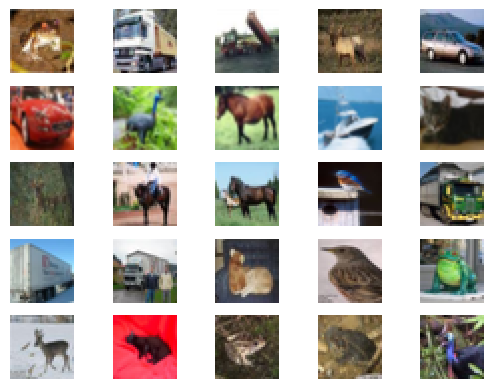

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# plot 25 images
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(X_train[i])
plt.show()


In [ ]:
print('Training images: {}'.format(X_train.shape))
print('Training images: {}'.format(y_train.shape))
print('Testing images: {}'.format(X_test.shape))
print('Testing images: {}'.format(y_test.shape))

Training images: (50000, 32, 32, 3)
Training images: (50000, 1)
Testing images: (10000, 32, 32, 3)
Testing images: (10000, 1)


In [ ]:
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Flatten()) #shape of 8192
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid')) #shape of 1
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)                 8

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
def define_generator(latent_dim):   
	model = Sequential()
	n_nodes = 128 * 8 * 8  #8192 nodes
	model.add(Dense(n_nodes, input_dim=latent_dim)) 
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))   
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
	return model  

test_gen = define_generator(100)
print(test_gen.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                            

In [ ]:
def define_gan(generator, discriminator):
	discriminator.trainable = False 
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
def load_real_samples():
	(trainX, _), (_, _) = load_data()
	X = trainX.astype('float32')
	X = (X - 127.5) / 127.5 
	return X

In [ ]:
def generate_real_samples(dataset, n_samples):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = ones((n_samples, 1)) 
	return X, y

def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

def generate_fake_samples(generator, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = generator.predict(x_input)
	y = zeros((n_samples, 1)) 
	return X, y

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2) 
	for i in range(n_epochs):
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch)
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = ones((n_batch, 1))     
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	g_model.save('cifar_generator_50epochs.h5')

In [ ]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = load_real_samples()
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=50)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step
Epoch>44, Batch 231/390, d1=0.716, d2=0.693 g=0.707
2/2 [==============================] - 0s 4ms/step
Epoch>44, Batch 232/390, d1=0.701, d2=0.701 g=0.723
2/2 [==============================] - 0s 4ms/step
Epoch>44, Batch 233/390, d1=0.694, d2=0.670 g=0.761
2/2 [==============================] - 0s 4ms/step
Epoch>44, Batch 234/390, d1=0.703, d2=0.668 g=0.731
2/2 [==============================] - 0s 4ms/step
Epoch>44, Batch 235/390, d1=0.695, d2=0.716 g=0.726
2/2 [==============================] - 0s 5ms/step
Epoch>44, Batch 236/390, d1=0.698, d2=0.697 g=0.699
2/2 [==============================] - 0s 4ms/step
Epoch>44, Batch 237/390, d1=0.694, d2=0.714 g=0.696
2/2 [==============================] - 0s 6ms/step
Epoch>44, Batch 238/390, d1=0.690, d2=0.704 g=0.697
2/2 [==============================] - 0s 6ms/step
Epoch>44, Batch 239/390, d1=0.691, d2=0.708 g=0.708
2/2 [=================

Epoch>50, Batch 390/390, d1=0.685, d2=0.691 g=0.729


In [ ]:
pwd 

'/content'

In [ ]:
ls

cifar_generator_20000epochs.h5  cifar_generator_50epochs.h5  sample_data/


1563/1563 [==============================] - 7s 4ms/step


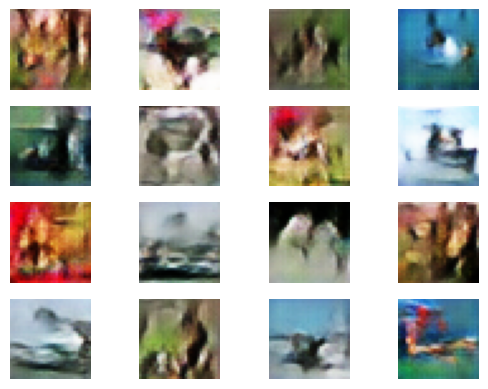

In [ ]:
from keras.models import load_model
from numpy.random import randn


# Plot generated images 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

# load model
model = load_model('cifar_generator_50epochs.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 50000)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 4)

#Note: CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse,
# ship, truck

In [ ]:
X.shape

(50000, 32, 32, 3)

In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
print('Training images: {}'.format(X_train.shape))
print('Training images: {}'.format(y_train.shape))
print('Testing images: {}'.format(X_test.shape))

print('Testing images: {}'.format(y_test.shape))

Training images: (50000, 32, 32, 3)
Training images: (50000, 1)
Testing images: (10000, 32, 32, 3)
Testing images: (10000, 1)


In [ ]:
X_train=np.concatenate([X,X_train])

In [ ]:
print('Training images: {}'.format(X_train.shape))
print('Training images: {}'.format(y_train.shape))
print('Testing images: {}'.format(X_test.shape))

print('Testing images: {}'.format(y_test.shape))

Training images: (100000, 32, 32, 3)
Training images: (50000, 1)
Testing images: (10000, 32, 32, 3)
Testing images: (10000, 1)


In [ ]:
X_train.shape

NameError: ignored

In [ ]:
print(y_train[:5])
y_train = y_train.reshape(-1,)
print(y_train[:5])

[[6]
 [9]
 [9]
 [4]
 [1]]
[6 9 9 4 1]


In [ ]:
y_test = y_test.reshape(-1,)

In [ ]:
dataset_class = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

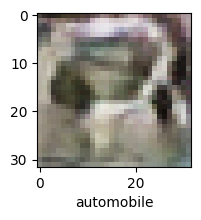

In [ ]:
def plot_image(X, y, i):
    plt.figure(figsize = (20,2))
    plt.imshow(X[i])
    plt.xlabel(dataset_class[y[i]])
plot_image(X_train, y_train, 5)

In [ ]:
#Normalization
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
import matplotlib.pyplot as plt
from keras.utils import np_utils
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import datasets, layers, models
cnnmodel = models.Sequential([
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])
cnnmodel.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 2304)              0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [ ]:
# with defaul adam learning rate = 0.001
cnnmodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [ ]:
import time
t1 = time.time()
history = cnnmodel.fit(X_train, y_train, epochs=100)
t2 = time.time()
print('\nTime: {} min'.format((t2-t1)/60))

In [ ]:
#train set accuracy
cnnmodel.evaluate(X_train,y_train)   

In [ ]:
#test set accuracy
cnnmodel.evaluate(X_test,y_test)  

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred1 = cnnmodel.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred1]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(11, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()